In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, random, cv2
warnings.filterwarnings('ignore')
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.image import load_img
from keras.layers import Conv2D, Flatten, Dropout, Dense, MaxPooling2D, BatchNormalization

In [3]:
train_dir = "../input/facial-expression-dataset/train/train/"
test_dir = "../input/facial-expression-dataset/test/test/"

In [4]:
def import_images(directory):
    image_paths = []
    labels = []
    
    for category in os.listdir(directory):
        for filename in os.listdir(directory+category):
            image_path = os.path.join(directory,category,filename)
            image_paths.append(image_path)
            labels.append(category)
        
    return image_paths, labels

In [5]:
train = pd.DataFrame()
train['image'], train['label'] = import_images(train_dir)
train = train.sample(frac=1).reset_index(drop=True)
train.head()

,image,label
0,../input/facial-expression-dataset/train/train...,surprise
1,../input/facial-expression-dataset/train/train...,angry
2,../input/facial-expression-dataset/train/train...,angry
3,../input/facial-expression-dataset/train/train...,angry
4,../input/facial-expression-dataset/train/train...,neutral


In [6]:
test = pd.DataFrame()
test['image'], test['label'] = import_images(test_dir)
test.head()

,image,label
0,../input/facial-expression-dataset/test/test/s...,surprise
1,../input/facial-expression-dataset/test/test/s...,surprise
2,../input/facial-expression-dataset/test/test/s...,surprise
3,../input/facial-expression-dataset/test/test/s...,surprise
4,../input/facial-expression-dataset/test/test/s...,surprise


## **Exploratory Data Analysis**

<AxesSubplot:xlabel='label', ylabel='count'>

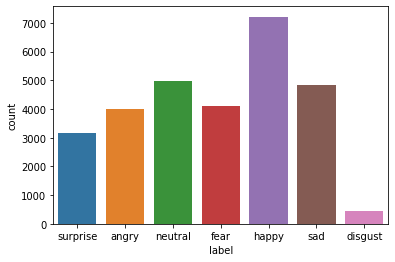

In [7]:
sns.countplot(train.label)

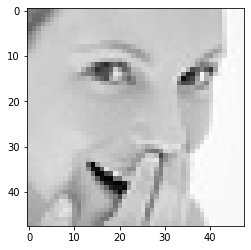

In [8]:
img = Image.open(train['image'][0])
plt.imshow(img,cmap='gray');

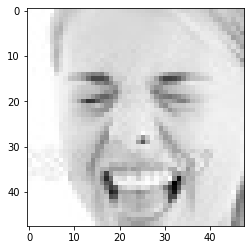

In [9]:
img = Image.open(train['image'][232])
plt.imshow(img,cmap='gray');

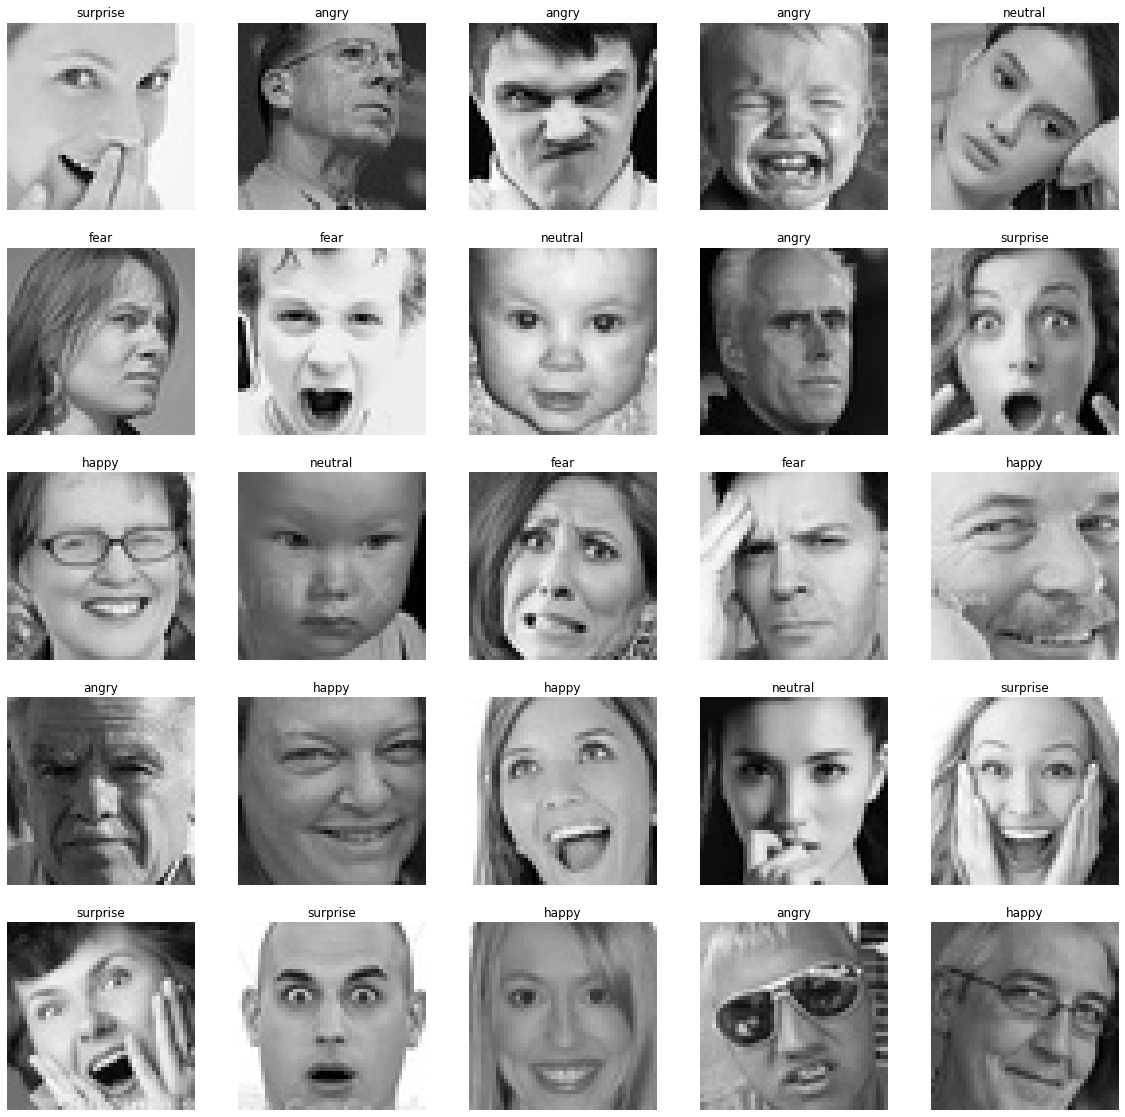

In [10]:
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for idx, file, label in files.itertuples():
    plt.subplot(5,5,idx+1)
    image = load_img(file)
    image = np.array(image)
    plt.imshow(image,cmap='gray')
    plt.title(label)
    plt.axis('off')

## **Feature Extraction**

In [11]:
def extract_features(images):
    features = []
    
    for file in tqdm(images):
        img = load_img(file,grayscale=True)
        img = np.array(img)
        features.append(img)
    
    features = np.array(features).reshape(len(features),48,48,1)
    return features

In [12]:
feat_train = extract_features(train['image'])
feat_test = extract_features(test['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

  0%|          | 0/7178 [00:00<?, ?it/s]

***Normalize the images***

In [13]:
X_train = feat_train / 255.
X_test = feat_test / 255.

***Convert labels to integers***

In [14]:
le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
y_train = to_categorical(y_train,num_classes=7)
y_test = to_categorical(y_test,num_classes=7)

## **Model Architecture**

In [16]:
cnn = Sequential()

# 1st Convolutional Layer
cnn.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',input_shape=(48,48,1)))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# 2nd Convolutional Layer
cnn.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# 3rd Convolutional Layer
cnn.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# 4th Convolutional Layer
cnn.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.32))

# Flatten
cnn.add(Flatten())

# 1st Fully-Connected Layer
cnn.add(Dense(units=512,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))

# 2nd Fully-Connected Layer
cnn.add(Dense(units=512,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.25))

# Output Layer
cnn.add(Dense(units=7,activation='softmax'))

2022-08-16 06:09:43.811235: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [17]:
cnn.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [18]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 128)       1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 23, 128)       512       
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 21, 21, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 256)       1

In [19]:
r = cnn.fit(x=X_train,y=y_train,batch_size=128,epochs=50,validation_data=(X_test,y_test))

2022-08-16 06:09:44.910043: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
225/225 [==============================] - 448s 2s/step - loss: 2.0283 - accuracy: 0.2630 - val_loss: 1.9376 - val_accuracy: 0.2471
Epoch 2/50
225/225 [==============================] - 445s 2s/step - loss: 1.5541 - accuracy: 0.4105 - val_loss: 1.5769 - val_accuracy: 0.3803
Epoch 3/50
225/225 [==============================] - 446s 2s/step - loss: 1.3491 - accuracy: 0.4886 - val_loss: 1.3027 - val_accuracy: 0.4971
Epoch 4/50
225/225 [==============================] - 444s 2s/step - loss: 1.2349 - accuracy: 0.5308 - val_loss: 1.6065 - val_accuracy: 0.4448
Epoch 5/50
225/225 [==============================] - 445s 2s/step - loss: 1.1501 - accuracy: 0.5607 - val_loss: 1.1594 - val_accuracy: 0.5580
Epoch 6/50
225/225 [==============================] - 444s 2s/step - loss: 1.0855 - accuracy: 0.5909 - val_loss: 1.1511 - val_accuracy: 0.5704
Epoch 7/50
225/225 [==============================] - 445s 2s/step - loss: 1.0149 - accuracy: 0.6168 - val_loss: 1.1092 - val_accuracy: 0.5847

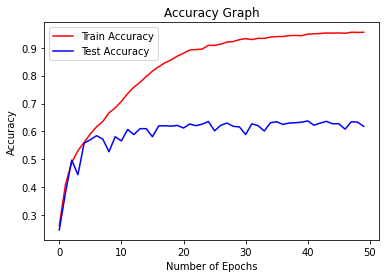

In [20]:
accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']
epochs = range(len(accuracy))
plt.plot(epochs,accuracy,'r',label='Train Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Test Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend();

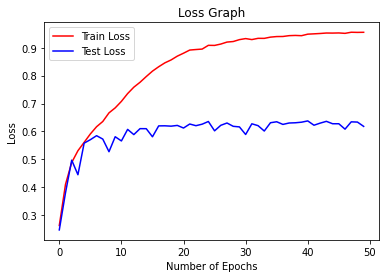

In [21]:
loss = r.history['loss']
val_loss = r.history['val_loss']
epochs = range(len(loss))

plt.plot(epochs,accuracy,'r',label='Train Loss')
plt.plot(epochs,val_accuracy,'b',label='Test Loss')
plt.title('Loss Graph')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend();

In [22]:
cnn.save('face_emotion_net.h5')
model = tf.keras.models.load_model('face_emotion_net.h5')

## **Test with an image of Test data**

Original Label: fear
Predicted Label: sad


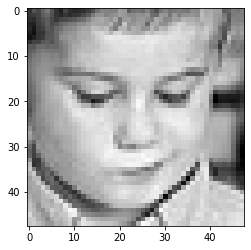

In [23]:
img_idx = random.randint(0,len(test))
print("Original Label:", test['label'][img_idx])
pred = cnn.predict(X_test[img_idx].reshape(1,48,48,1))
predicted_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Label:", predicted_label)
plt.imshow(X_test[img_idx].reshape(48,48),cmap='gray');